# Tutorial II: Using Runner Basics

The purpose of this tutorial is to learn how to combine error generation with our Runner, and thus be able to compare differend ML models' performance with errorified data. In this tutorial, instead of MNIST dataset, we'll be using smaller 8x8 images of handwrittern digits for performance reasons. The usecase is comparing some clustering algorithms using data with different amount of error.


First we have to import the required modules. Let's also disable some annoying warnings.

In [1]:
import warnings
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
from hdbscan import HDBSCAN
from numba.errors import NumbaDeprecationWarning, NumbaWarning
from numpy.random import RandomState
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from dpemu import runner
from dpemu.dataset_utils import load_digits_, load_mnist, load_fashion
from dpemu.filters.common import Missing, GaussianNoise, Clip
from dpemu.ml_utils import reduce_dimensions
from dpemu.nodes import Array
from dpemu.plotting_utils import visualize_best_model_params, visualize_scores, visualize_classes, \
    print_results_by_model

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaWarning)

/home/thalvari/PycharmProjects/dpEmu/venv/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/thalvari/PycharmProjects/dpEmu/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


The first phase of our pipeline is loading the dataset. You can also check the other two big datasets.

In [2]:
def get_data(argv):
    if argv[1] == "digits":
        data, labels, label_names, dataset_name = load_digits_(int(argv[2]))
    elif argv[1] == "mnist":
        data, labels, label_names, dataset_name = load_mnist(int(argv[2]))
    else:
        data, labels, label_names, dataset_name = load_fashion(int(argv[2]))
    return data, labels, label_names, dataset_name

Next we have to define our the root node for error generation. With all of the above datasets, the data is in one huge Numpy array, with different images in each row. Thus the root node's type needs to be Array. As for filters, we'll be using the same filters from the previous tutorial. Well also use Clip filter to get rid of negative pixel values.

In [3]:
def get_err_root_node():
    err_root_node = Array()
    # err_root_node.addfilter(GaussianNoise("mean", "std"))
    # err_root_node.addfilter(Clip("min_val", "max_val"))
    err_root_node.addfilter(Missing("probability", "missing_value_id"))
    return err_root_node

In this step we are defining the different error parameters for our filters we want to test the ML models with.

In [4]:
def get_err_params_list(data):
    # min_val = np.amin(data)
    # max_val = np.amax(data)
    # std_steps = np.linspace(0, max_val, num=8)
    # err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    p_steps = np.linspace(0, .7, num=8)
    err_params_list = [{"probability": p, "missing_value_id": 0} for p in p_steps]
    return err_params_list


The preprocessor code is run only once after the errorified data is generated, but before any of the ML models. The purpose of a preprocessor is to modify the errorified data to a usable format for the ML models. In this example we are using our premade pipeline for dimensionality reduction. Note that every dictionary element you add to the last return parameter will create a new column in the resulting Dataframe returned by the Runner. Now we will be using the reduced errorified data in our visualizations. 

In [5]:
class Preprocessor:
    def __init__(self):
        self.random_state = RandomState(42)

    def run(self, _, data, params):
        reduced_data = reduce_dimensions(data, self.random_state)
        return None, reduced_data, {"reduced_data": reduced_data}

Next we have to define the ML models used in this tutorial. Every model has to have a public run method, which gets the preprocessed data. Similarly the run method also returns a dictionary and every added key will create a new column in the resulting Dataframe returned by the Runner. In this tutorial we'll be testing three different clustering algorithms and use AMI and ARI scores for comparison.

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.random_state = RandomState(42)

    @abstractmethod
    def get_fitted_model(self, data, params):
        pass

    def run(self, _, data, params):
        labels = params["labels"]
        fitted_model = self.get_fitted_model(data, params)
        return {
            "AMI": round(adjusted_mutual_info_score(labels, fitted_model.labels_, average_method="arithmetic"), 3),
            "ARI": round(adjusted_rand_score(labels, fitted_model.labels_), 3),
        }


class KMeansModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        labels = params["labels"]
        n_classes = len(np.unique(labels))
        return KMeans(n_clusters=n_classes, random_state=self.random_state).fit(data)


class AgglomerativeModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        labels = params["labels"]
        n_classes = len(np.unique(labels))
        return AgglomerativeClustering(n_clusters=n_classes).fit(data)


class HDBSCANModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        return HDBSCAN(
            min_samples=params["min_samples"],
            min_cluster_size=params["min_cluster_size"]
        ).fit(data)

In this step we are defining the hyperparameters used by our models. This function returns a list of model/params_list pairs. Our Runner runs every model in this list with all different sets hyperparameters listed in the corresponding params_list -element. The scores for each model/params pair will become rows in the resulting Dataframe. The labels are only used for calculating the scores.

In [7]:
def get_model_params_dict_list(data, labels):
    n_data = data.shape[0]
    divs = [12, 25, 50]
    min_cluster_size_steps = [round(n_data / div) for div in divs]
    min_samples_steps = [1, 10]
    return [
        {"model": KMeansModel, "params_list": [{"labels": labels}]},
        {"model": AgglomerativeModel, "params_list": [{"labels": labels}]},
        {"model": HDBSCANModel, "params_list": [{
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples,
            "labels": labels
        } for min_cluster_size in min_cluster_size_steps for min_samples in min_samples_steps]},
    ]

Next we have to choose the visualizations we want to perform on our data and results. First we would like to visualize the hyperparameter-optimized scores for each of the models. Secondly we would like to see the best parameters for HDBSCAN given the error. Finally we would just like to visualize the dataset using the reduced_data column we added to the Dataframe.

In [8]:
def visualize(df, label_names, dataset_name, data):
    visualize_scores(
        df,
        score_names=["AMI", "ARI"],
        is_higher_score_better=[True, True],
        # err_param_name="std",
        err_param_name="probability",
        # title=f"{dataset_name} clustering scores with added gaussian noise",
        title=f"{dataset_name} clustering scores with missing pixels",
    )
    visualize_best_model_params(
        df,
        model_name="HDBSCAN #1",
        model_params=["min_cluster_size", "min_samples"],
        score_names=["AMI", "ARI"],
        is_higher_score_better=[True, True],
        # err_param_name="std",
        err_param_name="probability",
        title=f"Best parameters for {dataset_name} clustering"
    )
    visualize_classes(
        df,
        label_names,
        # err_param_name="std",
        err_param_name="probability",
        reduced_data_column="reduced_data",
        labels_column="labels",
        cmap="tab10",
        # title=f"{dataset_name} (n={data.shape[0]}) classes with added gaussian noise"
        title=f"{dataset_name} (n={data.shape[0]}) classes with missing pixels"
    )
    plt.show()

The job of the main function is to load the dataset and run the Runner. Since we are doing unsupervised learning, training data won't be needed. By default a subprocess is created for each element in err_params_list.

In [9]:
def main(argv):
    if len(argv) != 3 or argv[1] not in ["digits", "mnist", "fashion"]:
        exit(0)
    data, labels, label_names, dataset_name = get_data(argv)

    df = runner.run(
        train_data=None,
        test_data=data,
        preproc=Preprocessor,
        preproc_params=None,
        err_root_node=get_err_root_node(),
        err_params_list=get_err_params_list(data),
        model_params_dict_list=get_model_params_dict_list(data, labels),
    )

    print_results_by_model(df, ["missing_value_id", "min_val", "max_val", "labels", "reduced_data"])
    visualize(df, label_names, dataset_name, data)

Let's use the smaller Digits dataset which contains 1797 images.

100%|██████████| 8/8 [00:56<00:00,  6.65s/it]


Agglomerative #1
     AMI    ARI  probability  time_err  time_mod   time_pre
0  0.901  0.834          0.0  0.005866  0.172367  31.590767
1  0.822  0.778          0.1  0.006146  0.192286  33.296223
2  0.659  0.579          0.2  0.024894  0.472512  32.273932
3  0.532  0.454          0.3  0.022379  0.174513  33.094090
4  0.387  0.291          0.4  0.005005  0.111606  21.350726
5  0.228  0.160          0.5  0.004227  0.109263  20.979642
6  0.123  0.066          0.6  0.003810  0.119504  20.992544
7  0.052  0.020          0.7  0.004001  0.135423  21.563990
HDBSCAN #1
      AMI    ARI  min_cluster_size  min_samples  probability  time_err  time_mod   time_pre
0   0.862  0.744             150.0          1.0          0.0  0.005866  0.149247  31.590767
1   0.862  0.744             150.0         10.0          0.0  0.005866  0.124822  31.590767
2   0.908  0.883              72.0          1.0          0.0  0.005866  0.142653  31.590767
3   0.907  0.883              72.0         10.0          0.0  0.

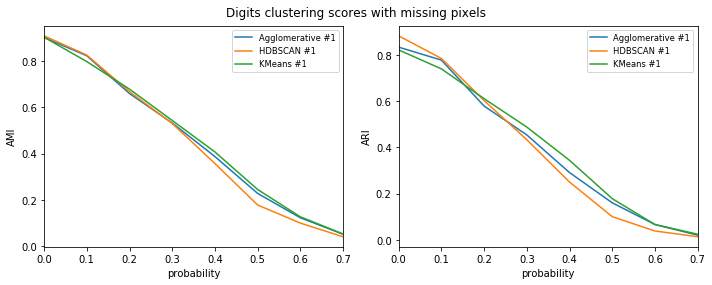

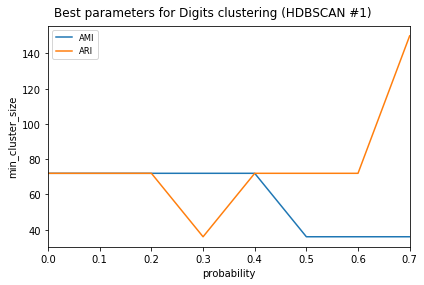

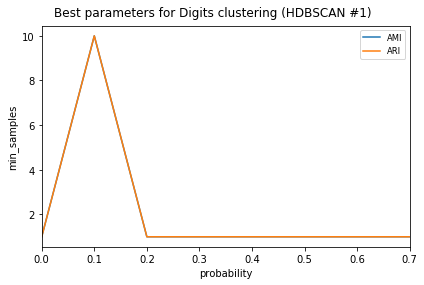

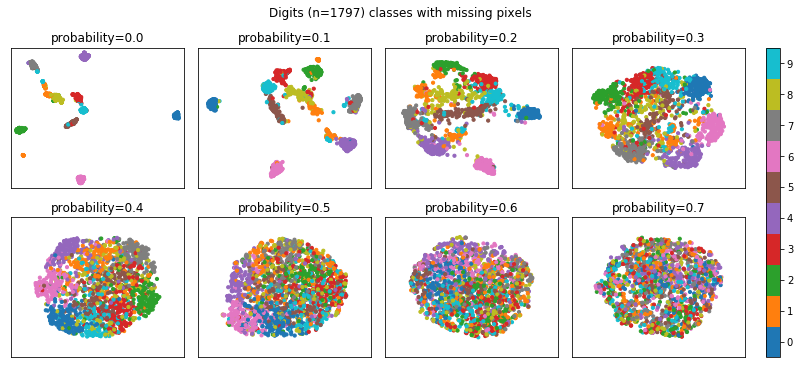

In [10]:
main(["", "digits", "1797"])

The code for this tutorial with added interactivity can be found [here](https://github.com/dpEmu/dpEmu/blob/master/examples/run_image_clustering_example.py).